In [11]:
suppressPackageStartupMessages(library(dplyr)) 
suppressPackageStartupMessages(library(Seurat))
suppressPackageStartupMessages(library(harmony))

library(ggplot2)
library(pheatmap)
library(RColorBrewer)
library(repr)

source("/projects/ps-renlab2/y2xie/scripts/basics.R")
source("/projects/ps-renlab2/y2xie/scripts/DPT_help.R")

library(future)
plan("multiprocess", workers = 32)
options(future.globals.maxSize = 64000 * 1024^2)

Warning message:
“package ‘pheatmap’ was built under R version 4.3.2”
Loading required package: Rcpp

Warning message:
“package ‘dichromat’ was built under R version 4.3.2”
Loading required package: viridisLite


Attaching package: ‘viridis’


The following object is masked from ‘package:scales’:

    viridis_pal




In [12]:
### Multiome kit barcode mapping
translate <- read.table("/projects/ps-renlab2/y2xie/ps-renlab/y2xie/projects/genome_ref/arc_bc-translation.txt", header = T, row.names = 1, sep = "\t")
translate$atac <- paste0(translate$atac, "-1")
translate$rna <- paste0(translate$rna, "-1")

In [13]:
### quick function
RunRNA2 <- function(obj, reduction = "pca", var = "none", batch.label = "none", k = 15) 
{
    if (var != "none") {
        obj <- SCTransform(obj, vars.to.regress = var, verbose = FALSE)
    }
    else {
        obj <- SCTransform(obj, verbose = FALSE)
    }
    obj <- RunPCA(obj, verbose = F)
    if (batch.label != "none") {
        obj <- RunHarmony(obj, group.by.vars = batch.label)
        reduction <- "harmony"
    }
    obj <- RunUMAP(obj, dims = 1:50, reduction = reduction, 
                   return.model = TRUE, seed.use = 921, metric = "cosine",
                   n.neighbors = k, min.dist = 0.1, n.components = 2L, umap.method = "uwot", 
                   uwot.sgd = TRUE, verbose = F)
    return(obj)
}

In [14]:
corder <- c('Lymphoid','Myeloid','Endocardial','Endothelial','Adipocyte',
            'Fibroblast','Neuronal','Pericyte','SM','Epicardial','aCM','vCM')

celltype_colors <- c(
    vCM = "#b94656",
    aCM = "#b95c38",
    Fibroblast = "#c0a13b",
    SM = "#71893b",
    Pericyte = "#6dbc5f",
    Epicardial = "#45c097",
    Endocardial = "#628ed6",
    Endothelial = "#6a70d7",
    Neuronal = "#5a3687",
    Myeloid = "#c074cc",
    Lymphoid = "#d16bad",
    Adipocyte = "#aa3d71"
)

cellsubtype_colors <- c(
    "#ac6175","#d4436b","#d54259","#c56969","#d44248","#b88077","#d23e31","#e83c21","#c27153","#c5663d","#ce632a","#e76717","#d53bc6",
    "#e04dbe","#d175b3","#cd3b9e","#9b5c82","#d5a1b9","#e74590","#be457a",
    "#ac7a61","#de9165","#a55f35","#7c5a3a","#e9c49b","#bb9c71","#bc924a","#84651d","#897244","#e6c572","#9f8e33",
    "#d1dc33","#b8c251",
    "#b0b69a","#708838","#b8d38b","#748b5a","#72d943","#65c45e",
    "#326d74","#143b44","#4a5967","#45617f","#27313f",
    "#3c6695","#0d1724",
    "#293251","#515ea0","#363e77","#4a5cc4","#121331","#1f225e","#2c2f94","#150e3f",
    "#5a3e98","#612eba","#402c53","#481f73",
    "#c68bdc","#cd6ee4","#da49f0","#d592cd","#df70c7","#eb4bcd","#ee4a9f","#e27eab",
    "#44dd94","#9fd5b5","#438867","#60d2a2","#afd9d0","#468c80","#6a827d","#5ad7cb",
    "#3c7ae7","#5f94e1","#3765ae"
)

## Read all multiome (10X / DPT) objects

In [ ]:
ref <- qs::qread("../reference/LV_RV_LA_RA.multiome.mrg.filt.MTless.silQC.curated.RNA.qs")
ref2 <- qs::qread("../reference/CAREHF/merge.rna.qs")
mmg <- qs::qread("FNIH_Heart_pool_DPT_SNG_SoupX.qs")

mmg[["RNA"]] <- as(mmg[["RNA"]], "Assay")
ref[["RNA"]] <- as(ref[["RNA"]], "Assay")
ref2[["RNA"]] <- as(ref2[["RNA"]], "Assay")

## Run Integration: 

In [ ]:
obj_list <- list(ref2, ref, mmg)
nfeature <- SelectIntegrationFeatures(obj_list, nfeatures = 3000)
obj_list <- PrepSCTIntegration(obj_list, anchor.features = nfeature)
obj.anchors <- FindIntegrationAnchors(obj_list, normalization.method = "SCT",
                                      anchor.features = nfeature, 
                                      dims = 1:50, reduction = "cca")
obj <- IntegrateData(anchorset = obj.anchors, normalization.method = "SCT")
gc()

In [ ]:
system("mkdir integration")
qs::qsave(obj.anchors, "integration/CAREHF_Multiome_DPT_RNA_int.anchors.qs")
qs::qsave(obj, "integration/CAREHF_Multiome_DPT_RNA_int.obj.qs")

In [ ]:
DefaultAssay(obj) <- "integrated"
obj <- RunPCA(obj, npcs = 30, verbose = FALSE)
obj <- RunUMAP(obj, reduction = "pca", dims = 1:30, verbose = FALSE)
obj <- FindNeighbors(obj, reduction = "pca", dims = 1:30)
suppressWarnings(obj <- FindClusters(object = obj, algorithm = 4, method = "igraph", weights = T, resolution = 1, verbose = F))

In [115]:
qs::qsave(obj, "integration/CAREHF_Multiome_DPT_RNA_int.obj.qs")

In [44]:
obj
ncol(ref) + ncol(ref2) + ncol(mmg)

An object of class Seurat 
73992 features across 713384 samples within 3 assays 
Active assay: integrated (3000 features, 3000 variable features)
 2 layers present: data, scale.data
 2 other assays present: RNA, SCT
 2 dimensional reductions calculated: pca, umap

[1] 713384

In [45]:
rm(obj.anchors); rm(obj_list); gc()

used        (Mb)     gc trigger  (Mb)     max used    (Mb)    
Ncells     8006737    427.7    25823592   1379.2    24168948   1290.8
Vcells 37282482151 284442.8 57737408210 440501.5 37418609188 285481.4

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Warning message:
“`legend.margin` must be specified using `margin()`
ℹ For the old behavior use `legend.spacing`”


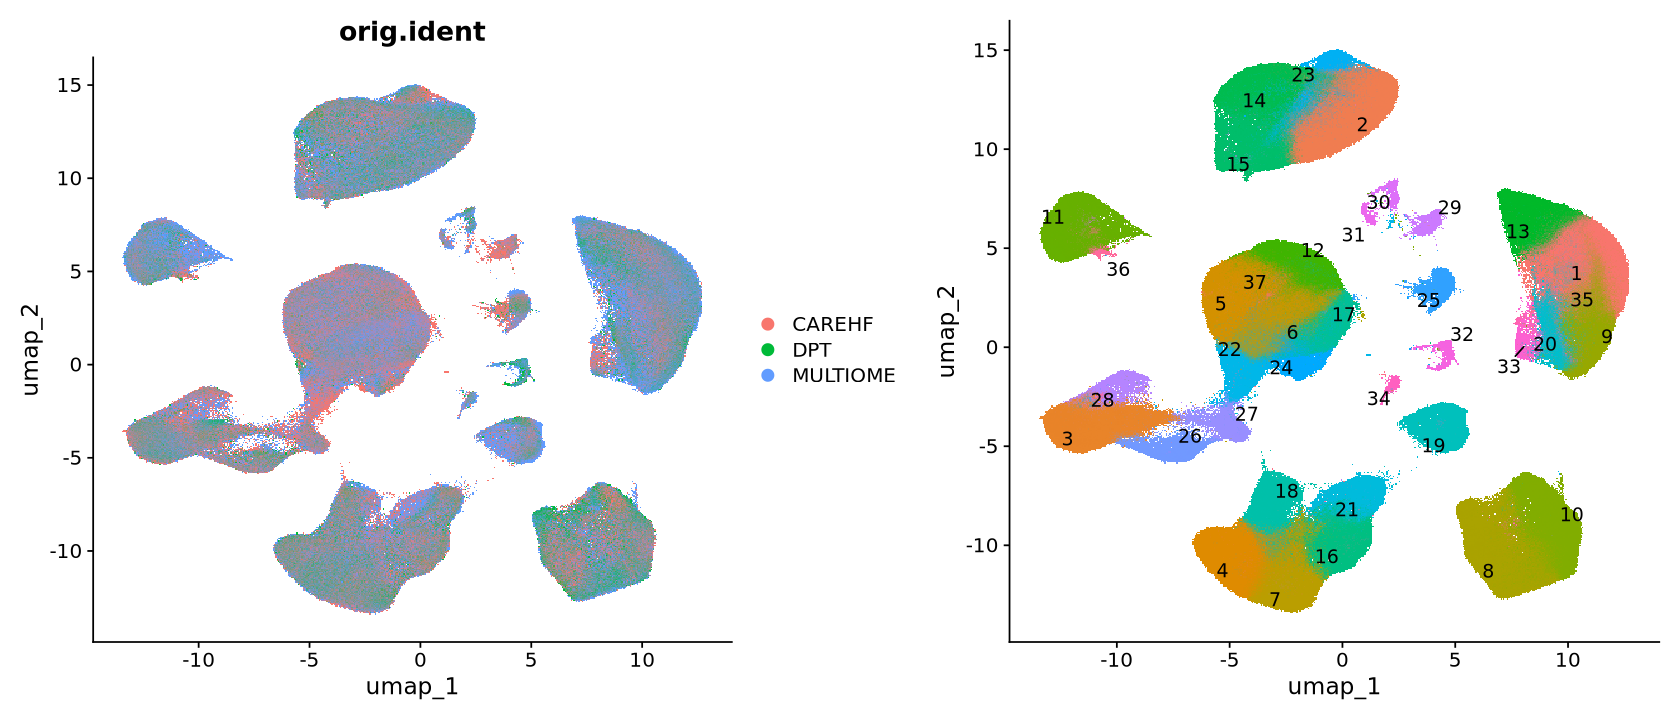

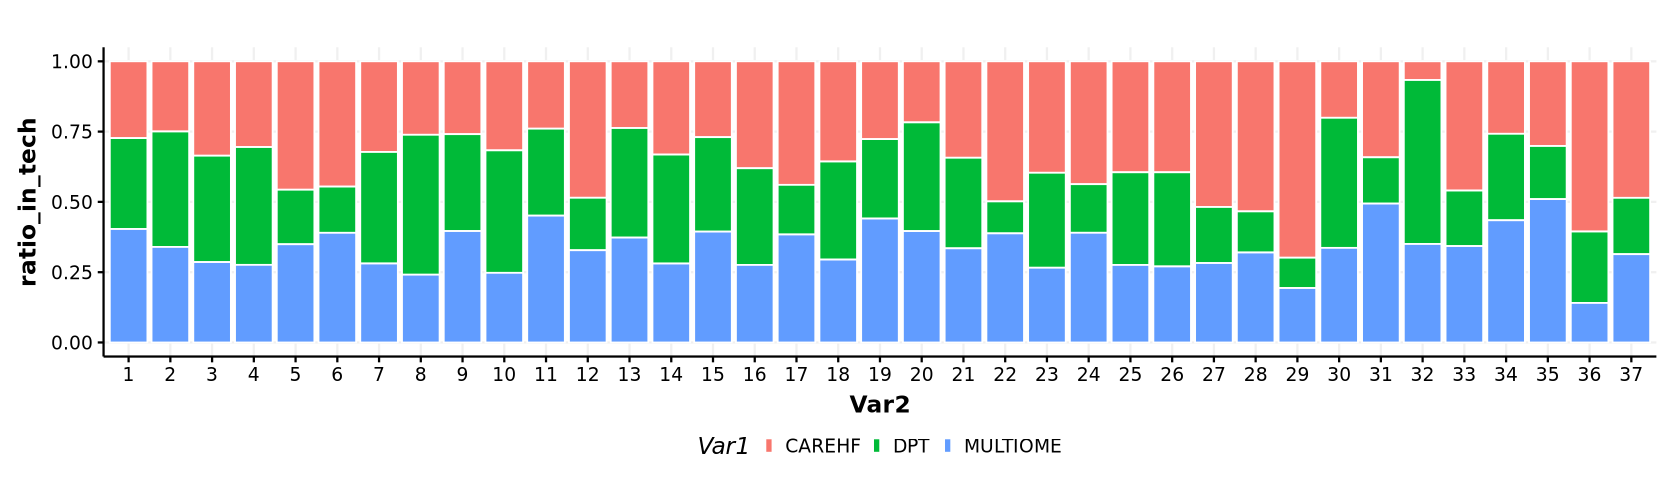

In [46]:
obj@meta.data[colnames(ref2), ]$orig.ident <- "CAREHF" ### single channel
obj@meta.data[colnames(mmg), ]$orig.ident <- "DPT" ### Droplet Paired-Tag
obj@meta.data[colnames(ref), ]$orig.ident <- "MULTIOME" ### multiplexed

options(repr.plot.width = 14, repr.plot.height = 6)

t1 <- DimPlot(obj, group.by = 'orig.ident')
t2 <- DimPlot(obj, label = T, repel = T) + NoLegend()
fig1 <- cowplot::plot_grid(t1, t2, rel_widths = c(1.2, 1))

fig1

options(repr.plot.width = 14, repr.plot.height = 4)
table(obj$orig.ident, obj$seurat_clusters) %>%
as.data.frame %>% group_by(Var1) %>% mutate(ratio_in_tech = Freq / sum(Freq)) %>%
ungroup() %>%
ggplot(aes(x = Var2, y = ratio_in_tech, fill = Var1)) + 
geom_col(position = "fill", color = "white") + 
theme_Publication()

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



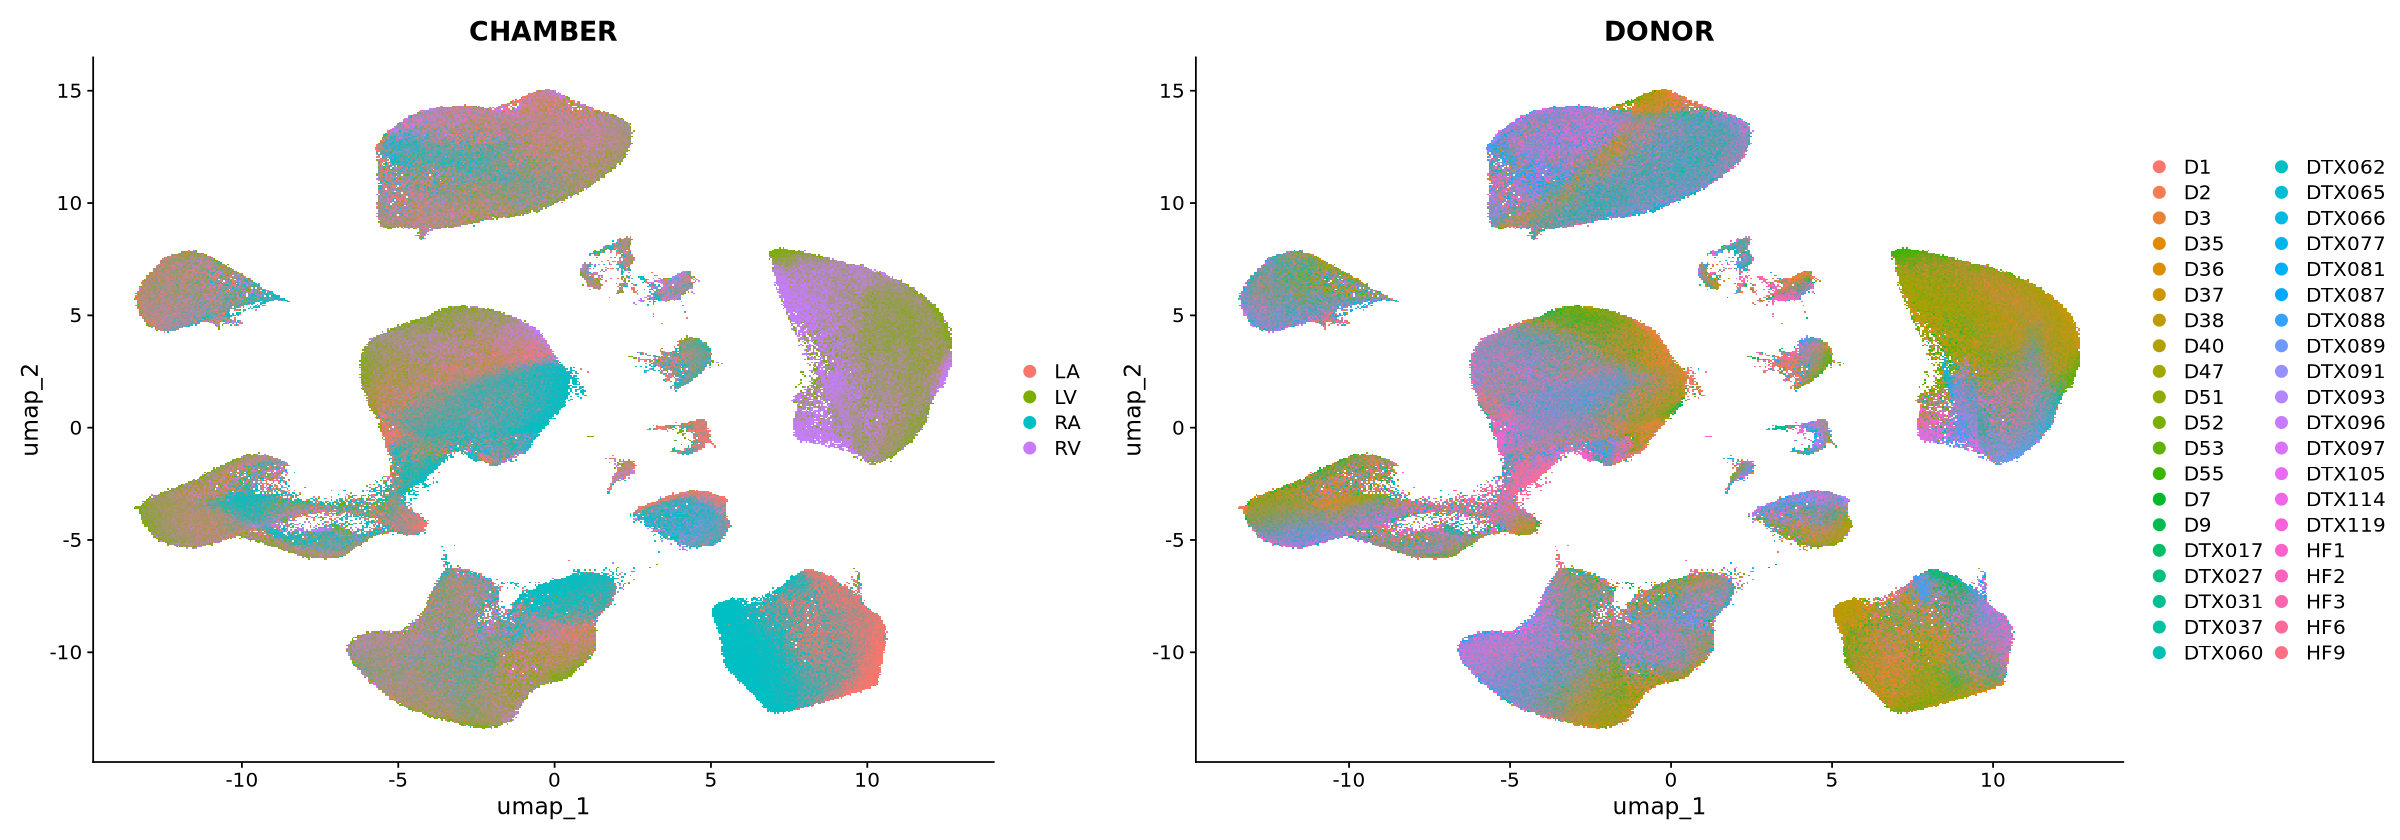

In [48]:
obj@meta.data[colnames(ref), c("CHAMBER", "DONOR")] <- ref@meta.data[,c("chamber", "donor")]
obj@meta.data[colnames(ref2), c("CHAMBER", "DONOR")] <- ref2@meta.data[,c("Chamber", "Donor")]
obj@meta.data[colnames(mmg), c("CHAMBER", "DONOR")] <- mmg@meta.data[,c("chamber", "Donor")]

options(repr.plot.width = 20, repr.plot.height = 7)
t1 <- DimPlot(obj, label = F, repel = T, group.by = "CHAMBER")
t2 <- DimPlot(obj, label = F, repel = T, group.by = "DONOR")
fig1 <- cowplot::plot_grid(t1, t2, rel_widths = c(1.7, 2))

fig1

## Read in donor information for a more detailed check

In [ ]:
dmeta <- read.table("../reference/Final_FNIH_Heart_10X.donor.xls")
dmeta2 <- read.table("../reference/CAREHF_FNIH_donor.info", sep = "\t", header = T)

tmeta2 <- dmeta2[,c("Patient.ID", "Donor.Group", "Age", "Gender", "Heart.Failure.etiology..ischemic.non.ischemic.", "Diabetes")] %>% 
distinct %>% setNames(c("Patient.ID", "Donor.Group", "Age", "Gender", "HF", "Diabetes"))
tmeta2[tmeta2$Gender == "male",]$Gender <- "M"
tmeta2[tmeta2$Gender == "female",]$Gender <- "F"

tmeta2[tmeta2$Diabetes %in% c("Yes","yes"),]$Diabetes <- "TRUE"
tmeta2[tmeta2$Diabetes %in% c("No"),]$Diabetes <- "FALSE"

tmeta2[tmeta2$Donor.Group %in% c("Carehf-Donor", "NON-DIABETIC"),]$Donor.Group <- "CONTROL"
tmeta2[tmeta2$Donor.Group %in% c("Carehf- HF") & tmeta2$Diabetes == "TRUE",]$Donor.Group <- "ICM DM"
tmeta2[tmeta2$Donor.Group %in% c("Carehf- HF") & tmeta2$Diabetes == "FALSE",]$Donor.Group <- "ICM NDM"

tmeta2[tmeta2$Donor.Group %in% c("CONTROL"),]$HF <- "CONTROL"
tmeta2[grep("^ICM", tmeta2$Donor.Group),]$HF <- "Ischemic"
tmeta2[grep("NICM", tmeta2$Donor.Group),]$HF <- "Non-ischemic"

tmeta2$condition <- "HF"
tmeta2[tmeta2$Donor.Group == "CONTROL",]$condition <- "CONTROL"

tmeta2 <- tmeta2 %>% distinct

In [ ]:
write.table(tmeta2, "../reference/CAREHF_FNIH_donor.simple.info", sep = "\t", quote = F, row.names = T, col.names = T)

In [52]:
unique(obj$DONOR) %>% length
intersect(tmeta2$Patient.ID, unique(obj$DONOR)) %>% length
### match

[1] 40

[1] 40

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



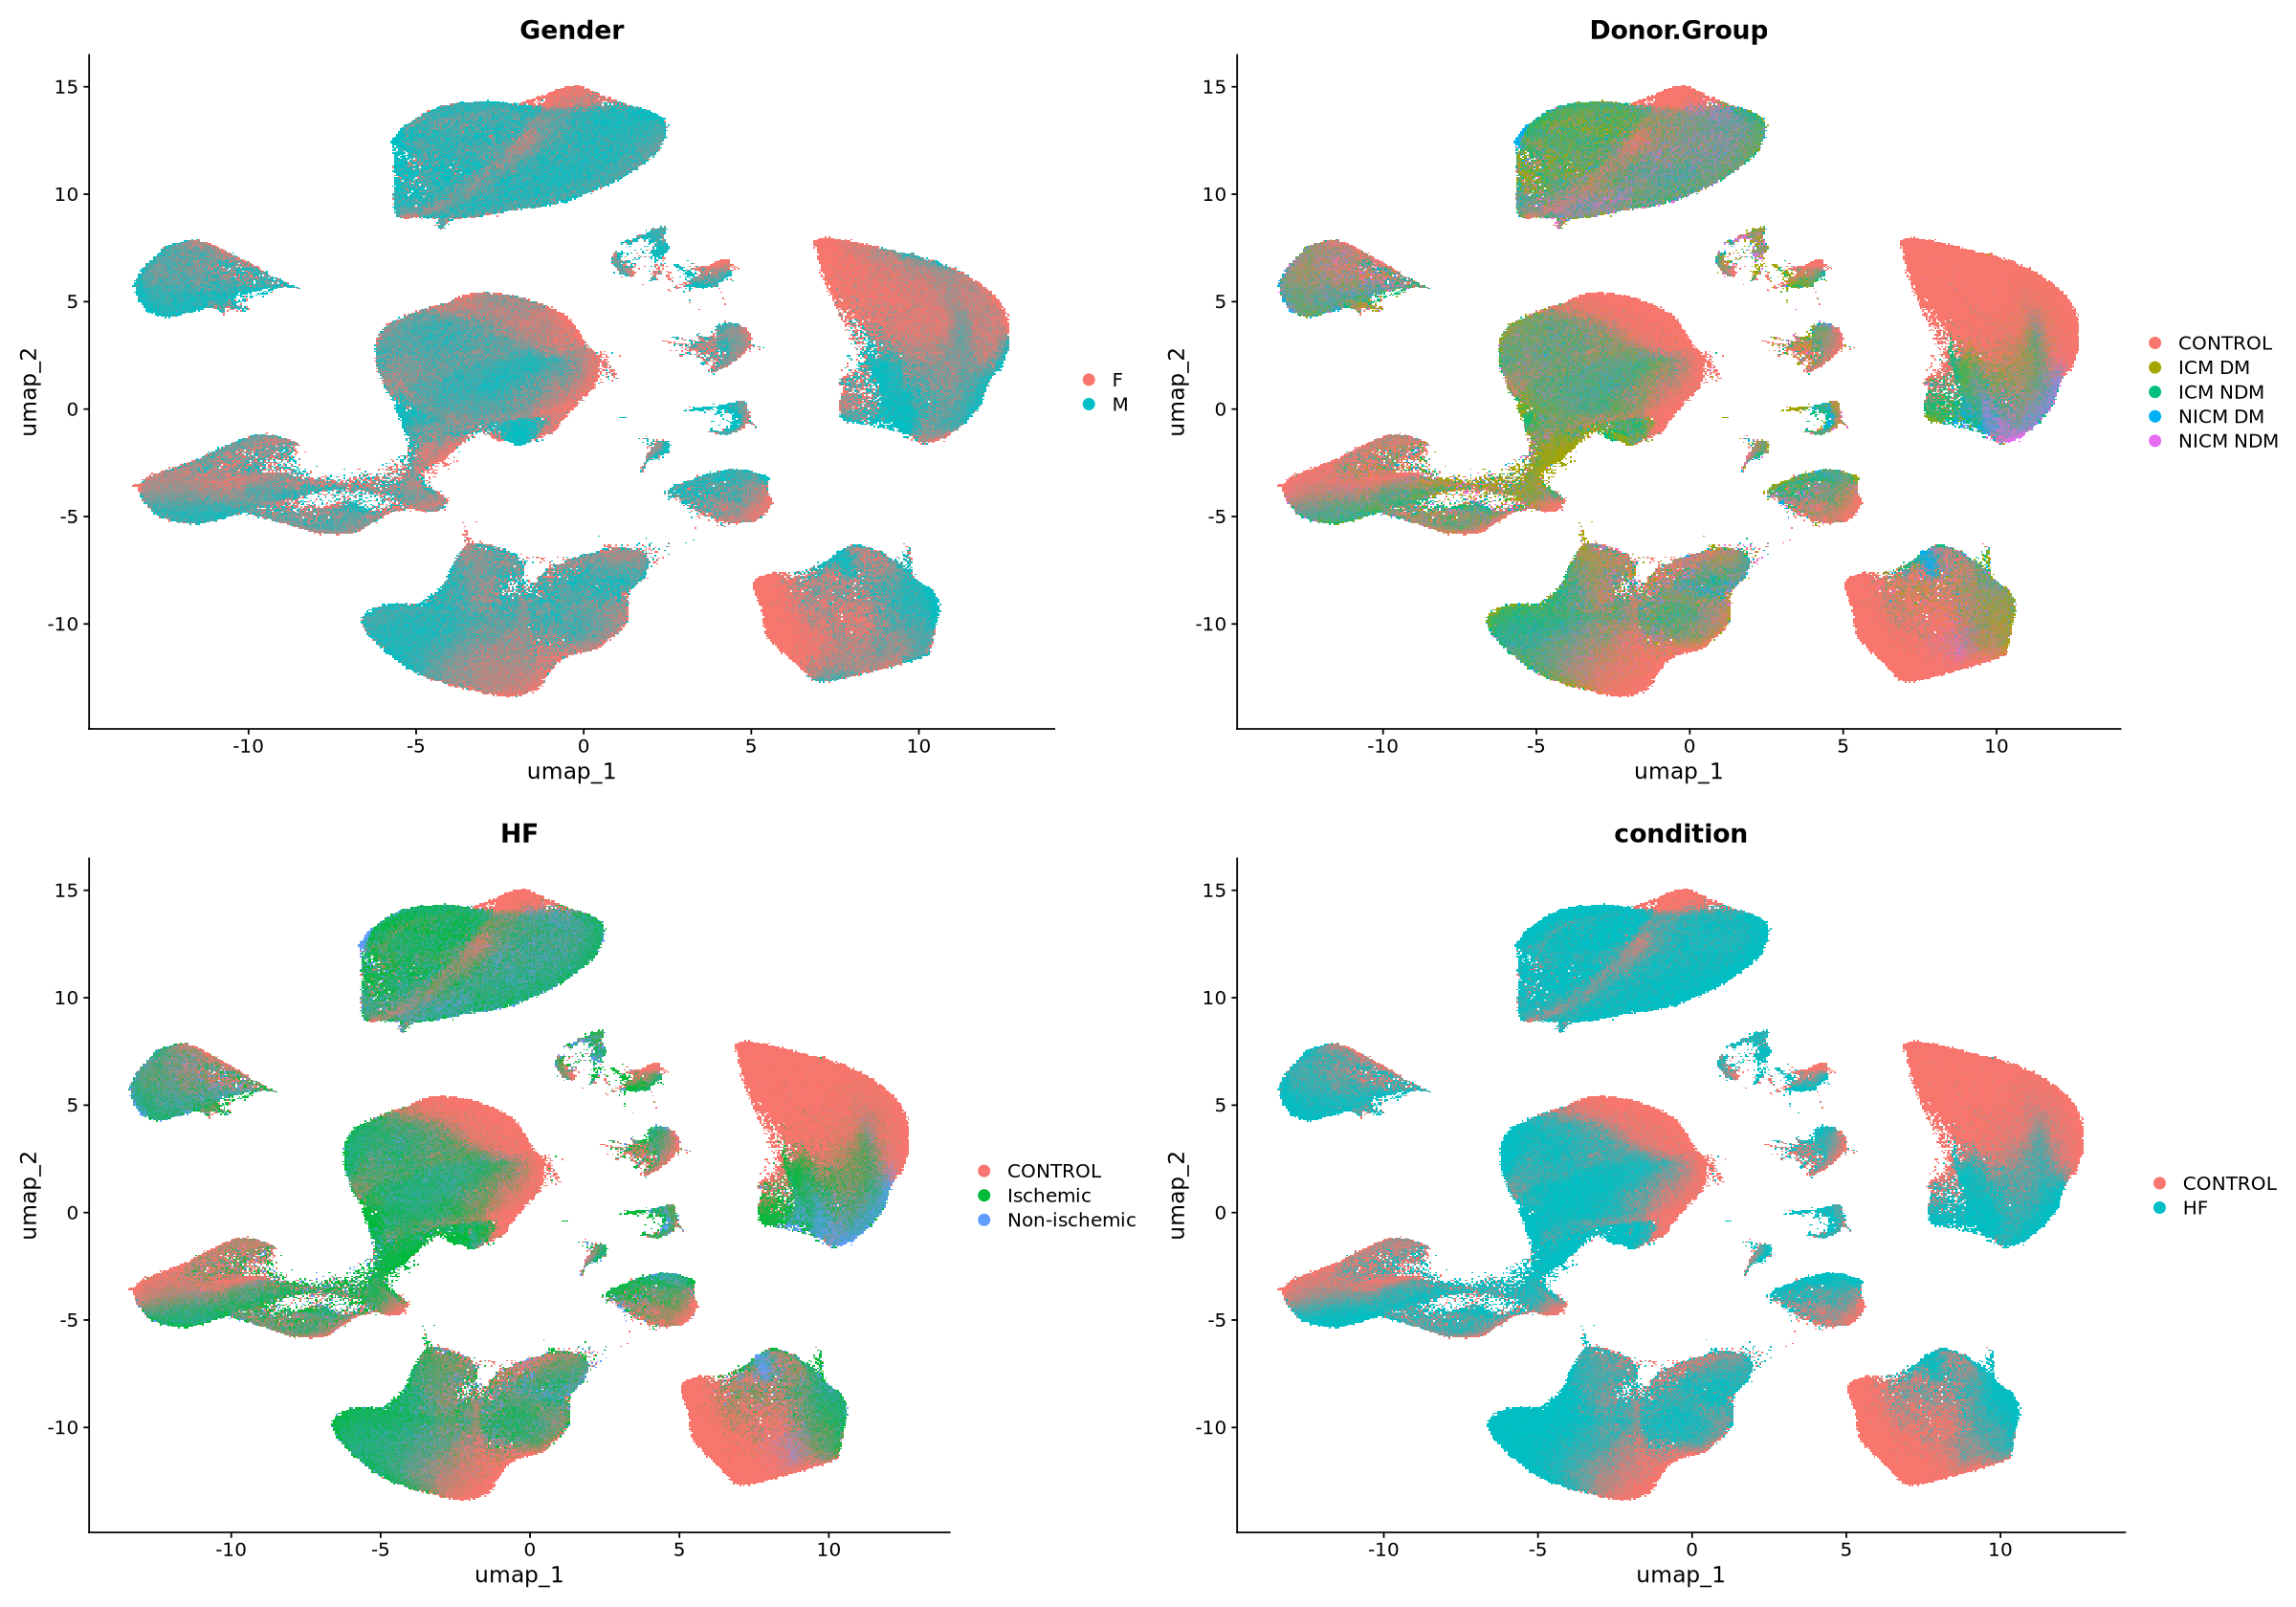

In [53]:
qry <- c("Patient.ID", "Donor.Group", "Age", "Gender", "HF", "Diabetes", "condition")
obj@meta.data[, qry] <- tmeta2[match(obj$DONOR, tmeta2$Patient.ID), qry]

options(repr.plot.width = 20, repr.plot.height = 14)
t1 <- DimPlot(obj, label = F, repel = T, group.by = "Gender")
t2 <- DimPlot(obj, label = F, repel = T, group.by = "Donor.Group")
t3 <- DimPlot(obj, label = F, repel = T, group.by = "HF")
t4 <- DimPlot(obj, label = F, repel = T, group.by = "condition")
fig1 <- cowplot::plot_grid(t1, t2, t3, t4, ncol = 2)

fig1

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



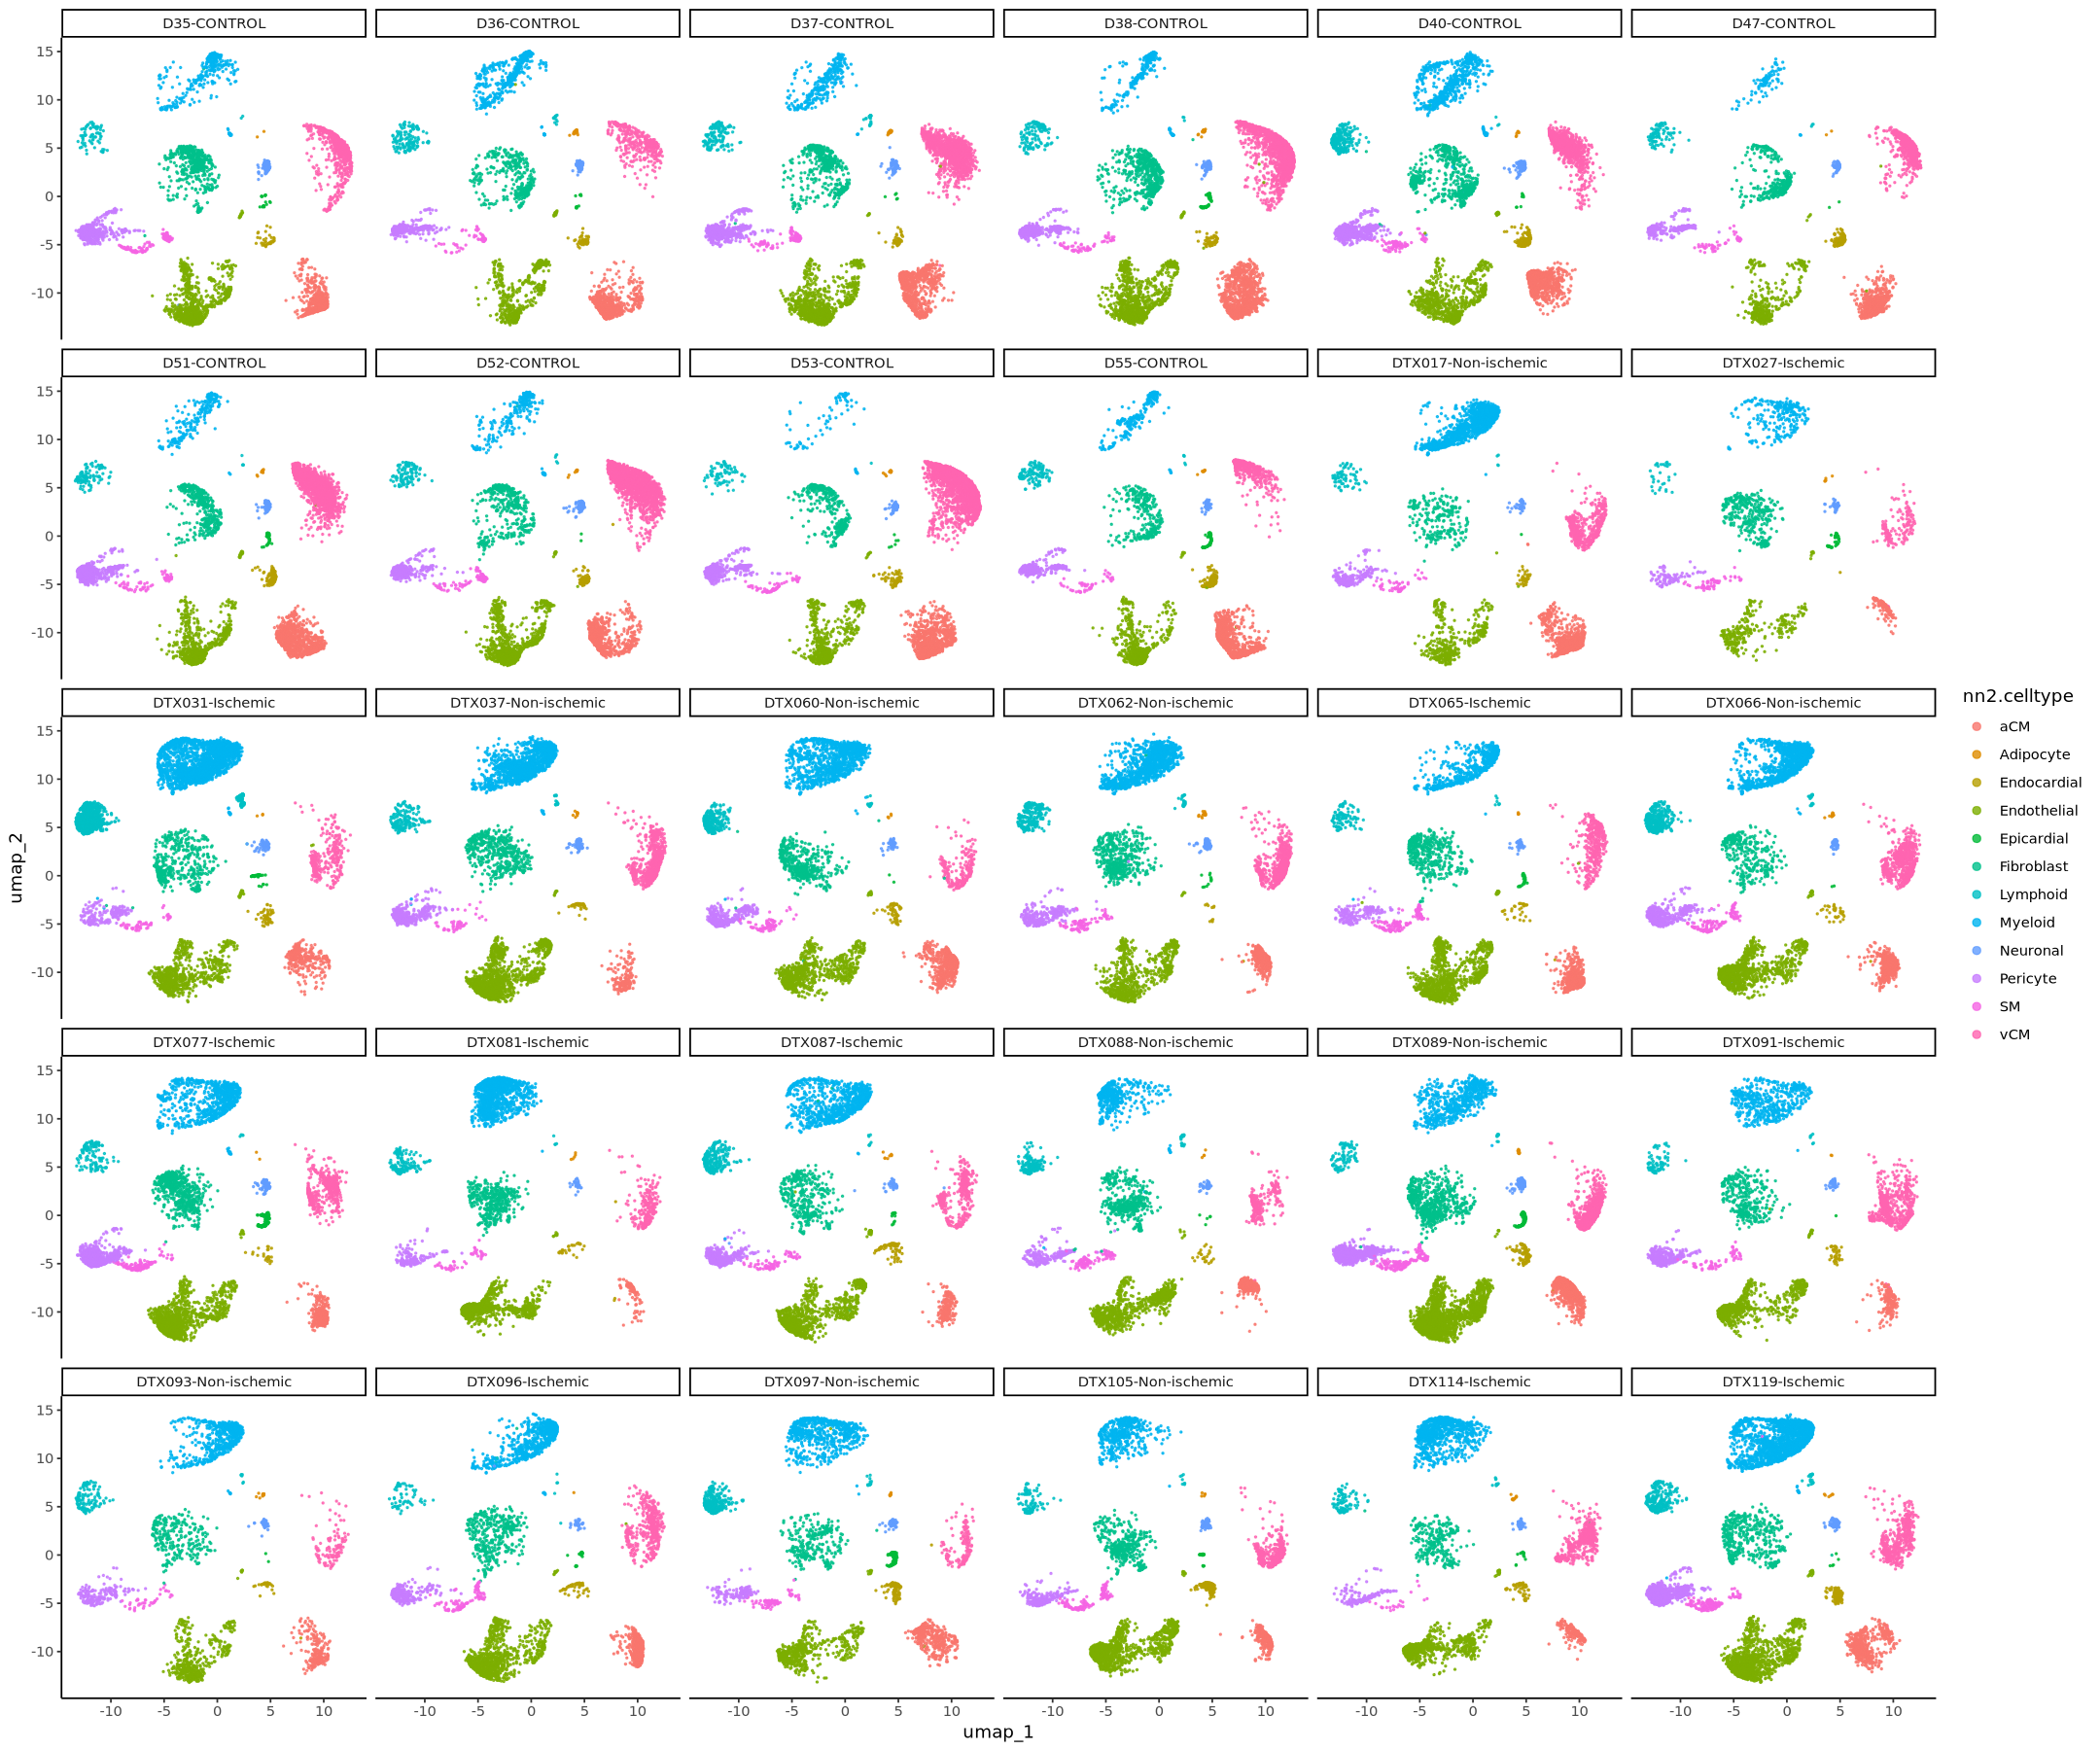

In [60]:
### FeaturePlot donor
qtable <- table(obj$DONOR, obj$orig.ident, obj$HF) %>% as.data.frame
qlabel <- distinct(qtable[qtable$Freq != 0,c("Var1", "Var3")]) 

np <- nrow(qtable[qtable$Var2 == "DPT" & qtable$Freq != 0, ])
prow <- ceiling(np/6)
pcol <- ceiling(np/prow)
dorder <- qtable[qtable$Var2 == "DPT" & qtable$Freq != 0, ] %>% arrange(Var3) %>% select(Var1) %>% unlist %>% unique %>% as.character

options(repr.plot.width = 3*pcol, repr.plot.height = 3*prow)
t1 <- DimPlot(obj, group.by = 'nn2.celltype', cells = rownames(obj@meta.data[obj$orig.ident == "DPT", ]),
              label = F, repel = T, split.by = "DONOR", ncol = pcol) + NoLegend()
tmp <- t1$data
tmp$HF <- qlabel[match(tmp$DONOR, qlabel$Var1),]$Var3
tmp %>%
filter(!is.na(umap_1)) %>%
mutate(DONOR = factor(DONOR, levels = dorder)) %>%
mutate(DONOR = paste0(DONOR, "-", HF)) %>%
ggplot(aes(x = umap_1, y = umap_2, color = nn2.celltype)) + 
geom_point(size = 0.3, alpha = 0.8) + 
theme_classic() + guides(color = guide_legend(override.aes = list(size = 2))) + 
facet_wrap(. ~ DONOR, nrow = prow)

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



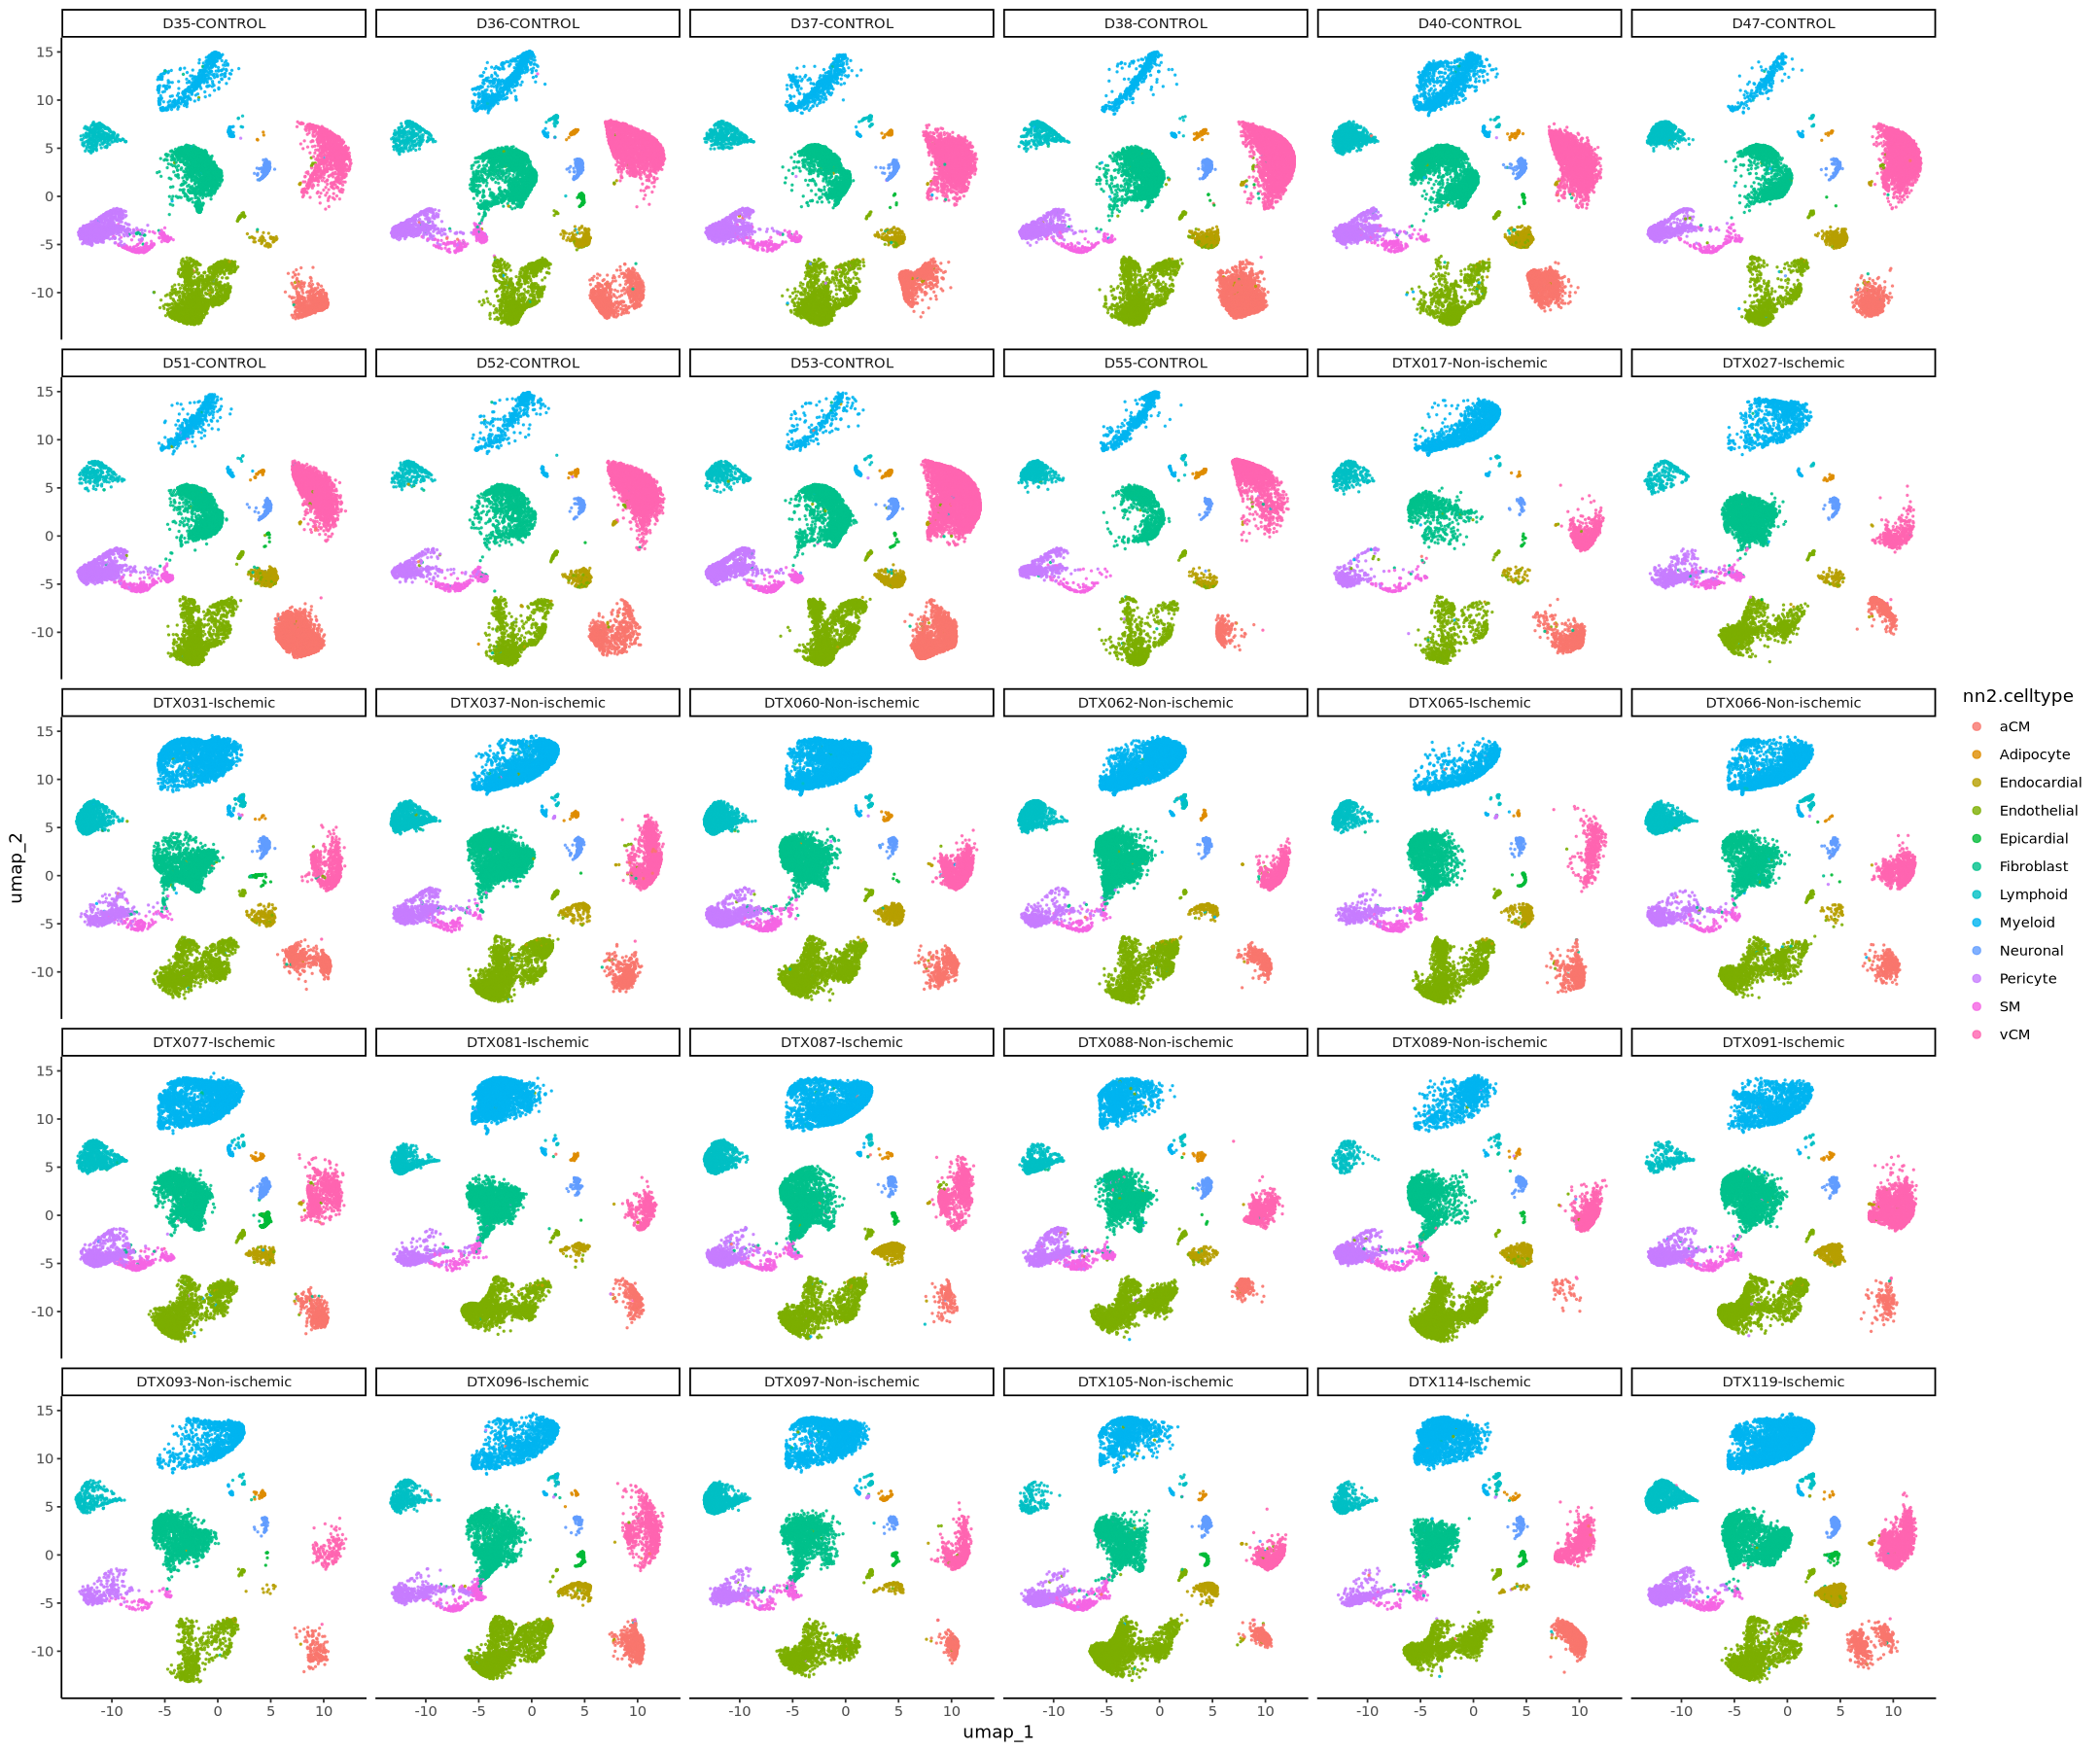

In [61]:
np <- nrow(qtable[qtable$Var2 == "MULTIOME" & qtable$Freq != 0, ])
prow <- ceiling(np/6)
pcol <- ceiling(np/prow)
dorder <- qtable[qtable$Var2 == "MULTIOME" & qtable$Freq != 0, ] %>% arrange(Var3) %>% select(Var1) %>% unlist %>% unique %>% as.character

options(repr.plot.width = 3*pcol, repr.plot.height = 3*prow)
t2 <- DimPlot(obj, group.by = 'nn2.celltype', cells = rownames(obj@meta.data[obj$orig.ident == "MULTIOME", ]),
              label = F, repel = T, split.by = "DONOR", ncol = pcol) + NoLegend()
tmp <- t2$data
tmp$HF <- qlabel[match(tmp$DONOR, qlabel$Var1),]$Var3
tmp %>%
filter(!is.na(umap_1)) %>%
mutate(DONOR = factor(DONOR, levels = dorder)) %>%
mutate(DONOR = paste0(DONOR, "-", HF)) %>%
ggplot(aes(x = umap_1, y = umap_2, color = nn2.celltype)) + 
geom_point(size = 0.3, alpha = 0.8) + 
theme_classic() + guides(color = guide_legend(override.aes = list(size = 2))) + 
facet_wrap(. ~ DONOR, nrow = prow)

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



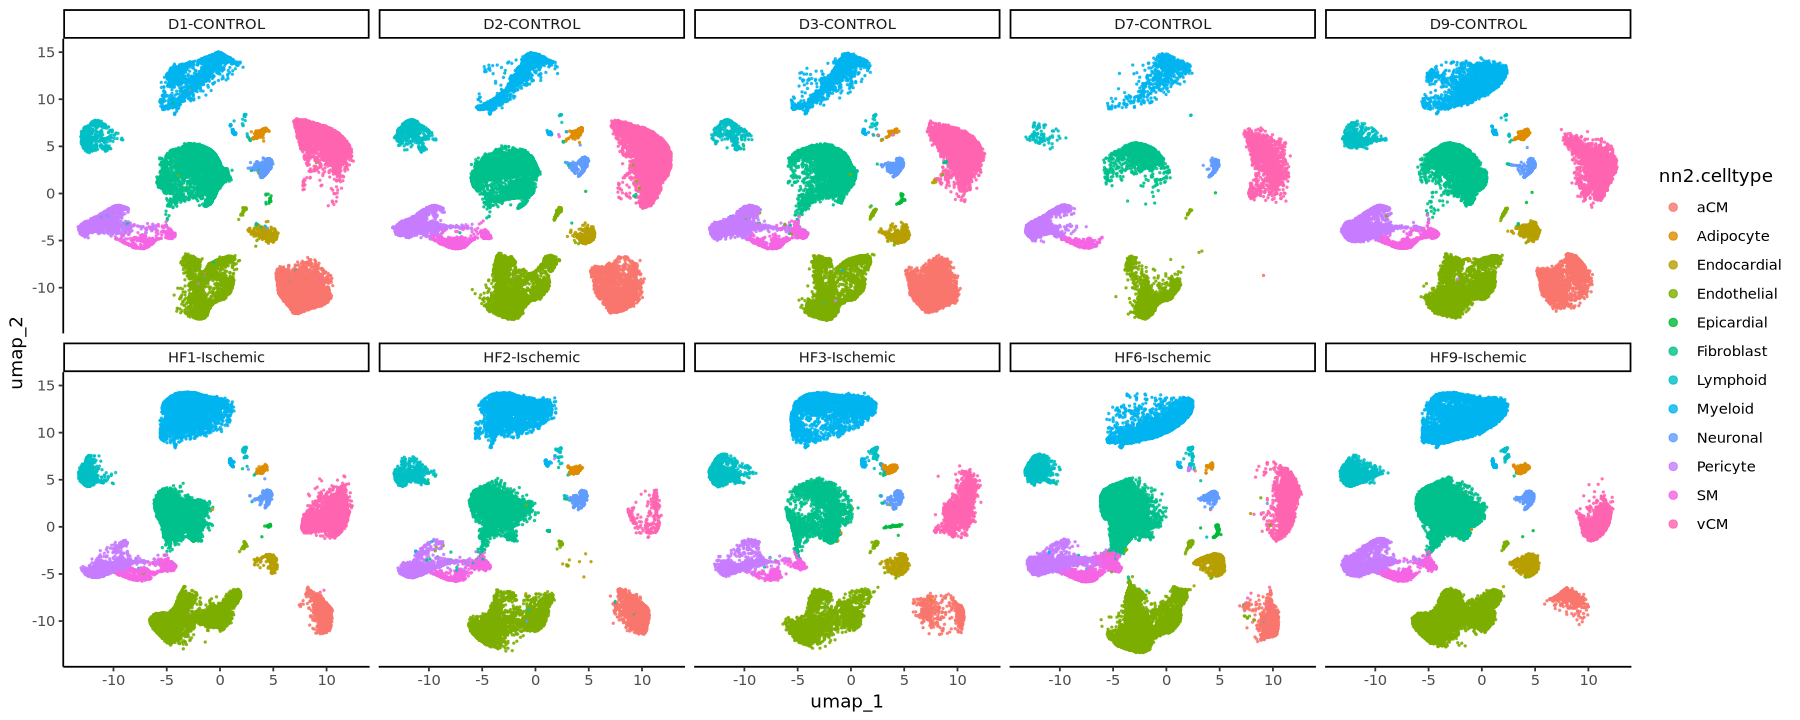

In [62]:
np <- nrow(qtable[qtable$Var2 == "CAREHF" & qtable$Freq != 0, ])
prow <- ceiling(np/6)
pcol <- ceiling(np/prow)
dorder <- qtable[qtable$Var2 == "CAREHF" & qtable$Freq != 0, ] %>% arrange(Var3) %>% select(Var1) %>% unlist %>% unique %>% as.character

options(repr.plot.width = 3*pcol, repr.plot.height = 3*prow)
t3 <- DimPlot(obj, group.by = 'nn2.celltype', cells = rownames(obj@meta.data[obj$orig.ident == "CAREHF", ]),
              label = F, repel = T, split.by = "DONOR", ncol = pcol) + NoLegend() 
tmp <- t3$data
tmp$HF <- qlabel[match(tmp$DONOR, qlabel$Var1),]$Var3
tmp %>%
filter(!is.na(umap_1)) %>%
mutate(DONOR = factor(DONOR, levels = dorder)) %>%
mutate(DONOR = paste0(DONOR, "-", HF)) %>%
ggplot(aes(x = umap_1, y = umap_2, color = nn2.celltype)) + 
geom_point(size = 0.3, alpha = 0.8) + 
theme_classic() + guides(color = guide_legend(override.aes = list(size = 2))) + 
facet_wrap(. ~ DONOR, nrow = prow)

## Label transfer (major cell types)

In [ ]:
### reference: FNIH
### transform distance matrix
NDnorm <- function(D){
    cellfilter <- (D[, ncol(D)] == 0)
    D <- 1 - (D/D[, ncol(D)])
    D[cellfilter, ] <- 1
    sd <- 1
    D <- 1 - exp(-D * (sd^2) / 4)
    D <- D / (rowSums(D) + 1e-6)
    return(D)
}

### use Jingtian method
library(RANN) ### maybe I should use annoy
rpca <- obj@reductions$pca@cell.embeddings[colnames(ref), ]
qpca1 <- obj@reductions$pca@cell.embeddings[colnames(ref2), ]
qpca2 <- obj@reductions$pca@cell.embeddings[colnames(mmg), ]

### k = 25
qidx1 <- nn2(data = rpca, query = qpca1, k = 25, searchtype = "standard")
qidx2 <- nn2(data = rpca, query = qpca2, k = 25, searchtype = "standard")

qidx1[[3]] <- NDnorm(qidx1[[2]])
qidx2[[3]] <- NDnorm(qidx2[[2]])

In [ ]:
qtable <- data.frame(label = ref$cell.major_types, stringsAsFactors = TRUE)
labelref <- mltools::one_hot(data.table::as.data.table(qtable))
pred <- data.frame(predict.label = rep(NA, nrow(qpca2)), 
                   predict.score = rep(NA, nrow(qpca2))) 

chunk_size <- 1000  # save time
for (chunk_start in seq(1, nrow(qpca2), by = chunk_size)) {
    chunk_end <- min(chunk_start + chunk_size - 1, nrow(qpca2))
    chunk_indices <- seq(chunk_start, chunk_end)

    # Get the relevant distance and neighbor indices for this chunk
    D_chunk <- qidx2[[3]][chunk_indices, , drop = FALSE]
    G_chunk <- qidx2[[1]][chunk_indices, , drop = FALSE]

    # Multiply distances by the one-hot encoded labels for the neighbors
    result <- sapply(1:nrow(G_chunk), function(i) {
        (colSums(D_chunk[i, ] * labelref[G_chunk[i, ], ]))
    }) %>% t
    # Store the results in the cluster dataframe
    pred$predict.label[chunk_indices] <- colnames(result)[apply(result, 1, which.max)]
    pred$predict.score[chunk_indices] <- apply(result, 1, max)
}

In [ ]:
### map for CAREHF
pred <- data.frame(predict.label = rep(NA, nrow(qpca1)), 
                   predict.score = rep(NA, nrow(qpca1))) 

for (chunk_start in seq(1, nrow(qpca1), by = chunk_size)) {
    chunk_end <- min(chunk_start + chunk_size - 1, nrow(qpca1))
    chunk_indices <- seq(chunk_start, chunk_end)

    # Get the relevant distance and neighbor indices for this chunk
    D_chunk <- qidx1[[3]][chunk_indices, , drop = FALSE]
    G_chunk <- qidx1[[1]][chunk_indices, , drop = FALSE]

    # Multiply distances by the one-hot encoded labels for the neighbors
    result <- sapply(1:nrow(G_chunk), function(i) {
        (colSums(D_chunk[i, ] * labelref[G_chunk[i, ], ]))
    }) %>% t
    # Store the results in the cluster dataframe
    pred$predict.label[chunk_indices] <- colnames(result)[apply(result, 1, which.max)]
    pred$predict.score[chunk_indices] <- apply(result, 1, max)
}

rownames(pred) <- colnames(ref2)
write.table(pred, "integration/CAREHF_majortype_prediction.toFNIH.txt", 
            sep = "\t", quote = F, row.names = T, col.names = T)

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Warning message:
“`legend.margin` must be specified using `margin()`
ℹ For the old behavior use `legend.spacing`”


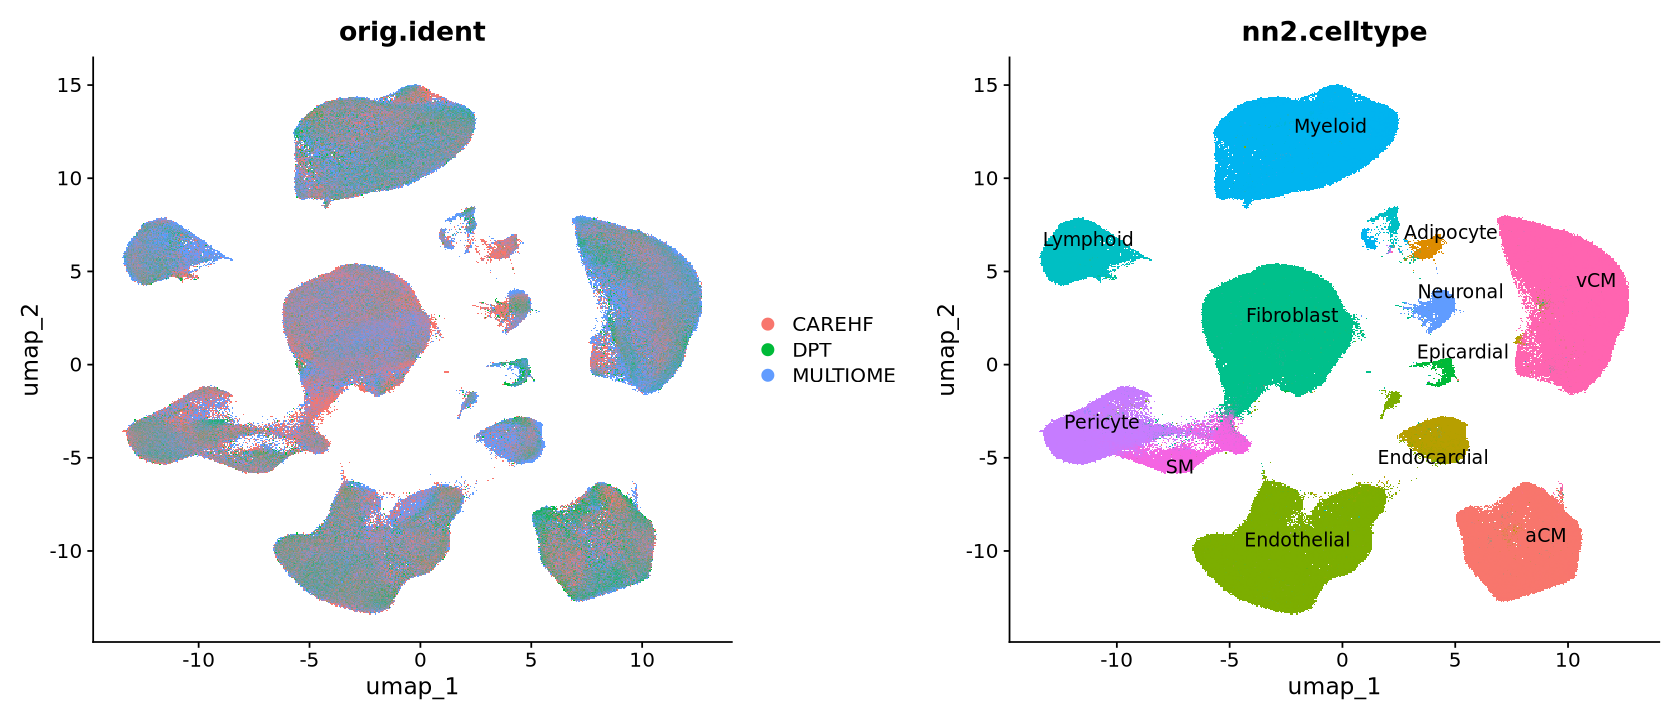

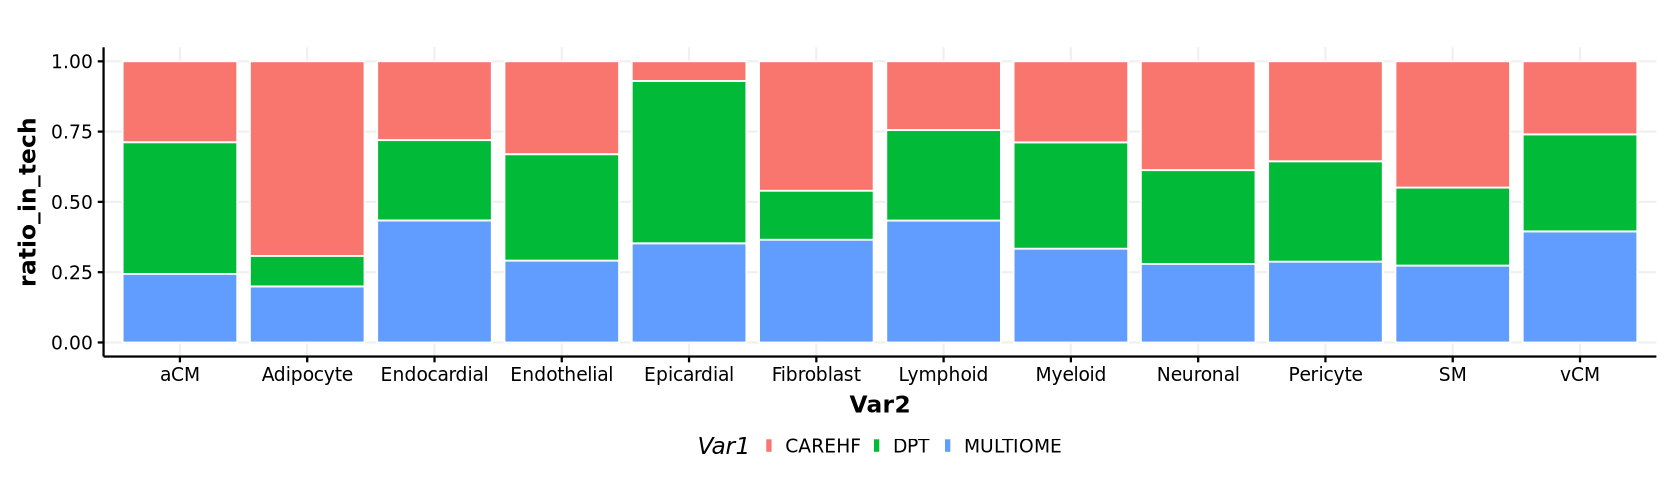

In [74]:
### Plot predicted UMAP
pred1 <- read.table("integration/DPT_majortype_prediction.toFNIH.txt", row.names = 1, header = T, sep = "\t")
pred2 <- read.table("integration/CAREHF_majortype_prediction.toFNIH.txt", row.names = 1, header = T, sep = "\t")
pred <- rbind(pred1, pred2)
pred$predict.label <- gsub("label_", "", pred$predict.label)

### Add predicted label
obj$nn2.celltype <- obj$nn2.celltype_scores <- NA
obj@meta.data[colnames(ref), c("nn2.celltype")] <- obj@meta.data[colnames(ref), c("cell.major_types")] ### original
obj@meta.data[rownames(pred), c("nn2.celltype", "nn2.celltype_scores")] <- pred ### prediction

options(repr.plot.width = 14, repr.plot.height = 6)

t1 <- DimPlot(obj, group.by = 'orig.ident')
t2 <- DimPlot(obj, group.by = "nn2.celltype", label = T, repel = T) + NoLegend()
fig1 <- cowplot::plot_grid(t1, t2, rel_widths = c(1.2, 1))

fig1

options(repr.plot.width = 14, repr.plot.height = 4)
table(obj$orig.ident, obj$nn2.celltype) %>%
as.data.frame %>% group_by(Var1) %>% mutate(ratio_in_tech = Freq / sum(Freq)) %>%
ungroup() %>%
ggplot(aes(x = Var2, y = ratio_in_tech, fill = Var1)) + 
geom_col(position = "fill", color = "white") + 
theme_Publication()

In [8]:
qs::qsave(obj, "integration/CAREHF_Multiome_DPT_RNA_int.obj.qs")

## Output integrated embedding for Hi-C annotation

In [ ]:
obj1 <- RunUMAP(obj, reduction = "pca", dims = 1:30, return.model = T, verbose = F)
saveRDS(obj1@reductions$umap@misc$model, file = "integration/coembed/CAREHF_Multiome_DPT_RNA_int_umap_model.rds")

In [ ]:
system("mkdir integration/coembed")
pca_loadings <- obj[["pca"]]@feature.loadings
write.csv(pca_loadings, file = "integration/coembed/CAREHF_Multiome_DPT_RNA_int_pca_loadings.csv", row.names = TRUE)
pca_embeddings <- Embeddings(obj, "pca")
write.csv(pca_embeddings, file = "integration/coembed/CAREHF_Multiome_DPT_RNA_int_pca_embeddings.csv", row.names = TRUE)
write.table(obj@reductions$pca@stdev, "integration/coembed/CAREHF_Multiome_DPT_RNA_int_pca_stdev.csv", row.names = F, col.names = F, sep = "\t", quote = F)

In [ ]:
library(SeuratDisk)
SaveH5Seurat(obj1, filename = "integration/CAREHF_Multiome_DPT_RNA_int.obj.h5Seurat")
Convert("integration/CAREHF_Multiome_DPT_RNA_int.obj.h5Seurat", dest = "h5ad")

## Label transfer (cell subtypes)

In [286]:
### also read in non-corrected start from scratch
flist2 <- list()
i = 1 
for (file in list.files('integration/subcluster/integrated/', pattern = ".*._int_from_cca_harmony_int_from_cca_subtype.predict.k5.xls$")){
    dataset <- gsub("^([^_]+)_.*", "\\1", file)
    celltype <- gsub("^([^_]+)_([^_]+)_.*", "\\2", file)
    if(!grepl("new", celltype)){
        tmp <- read.table(paste0('integration/subcluster/integrated/', file), header = T) %>% mutate(dataset = dataset, celltype = celltype)
        flist2[[i]] <- tmp
        i = i + 1
    }
}

flist2 <- do.call(rbind, flist2)
flist2$predict.label <- gsub("label_", "", flist2$predict.label)
table(flist2$dataset)


CAREHF    DPT 
252832 131297 


    FALSE      TRUE 
0.2953305 0.7046695 


    FALSE      TRUE 
0.3423069 0.6576931 

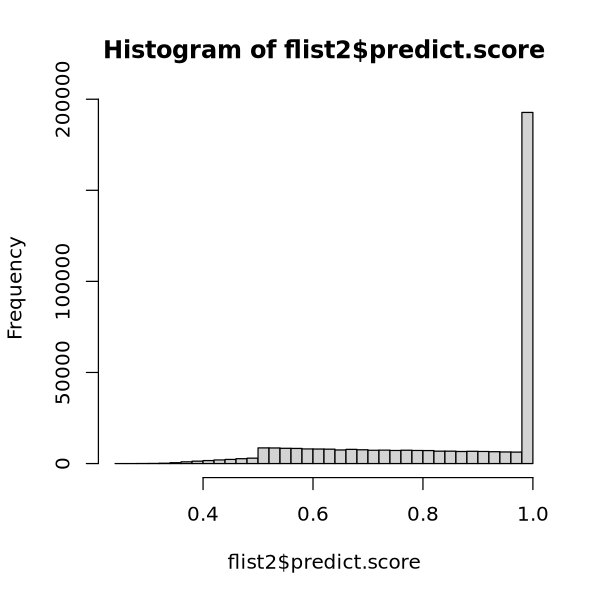

In [287]:
options(repr.plot.width = 5, repr.plot.height = 5)
hist(flist2$predict.score, breaks = 50)

table(flist2$predict.score > 0.75)/nrow(flist2)
table(flist2$predict.score > 0.8)/nrow(flist2)

Warning message:
“`legend.margin` must be specified using `margin()`
ℹ For the old behavior use `legend.spacing`”
Warning message:
“`legend.margin` must be specified using `margin()`
ℹ For the old behavior use `legend.spacing`”


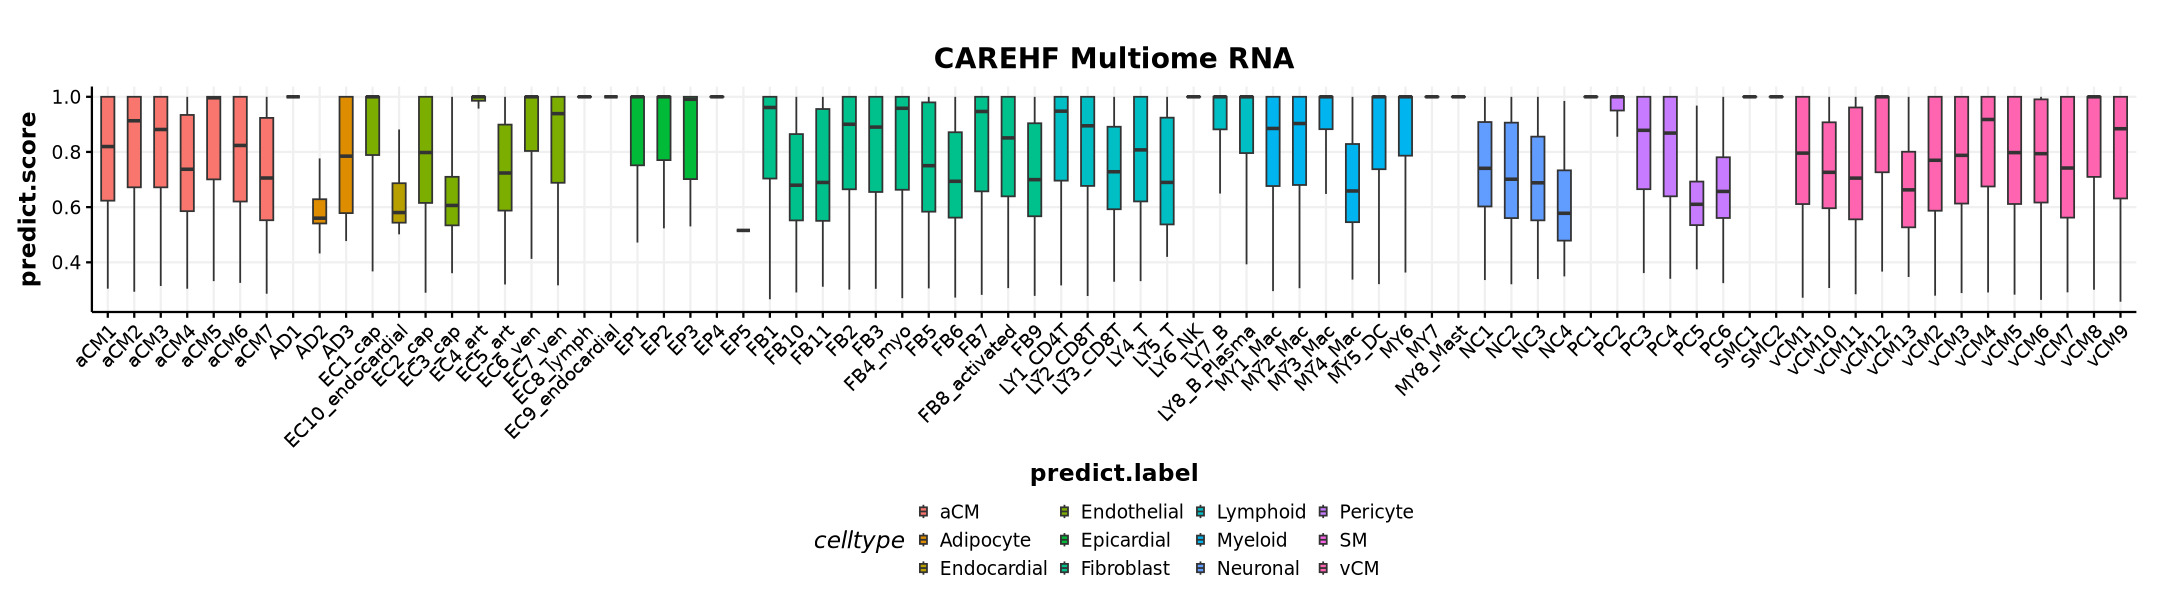

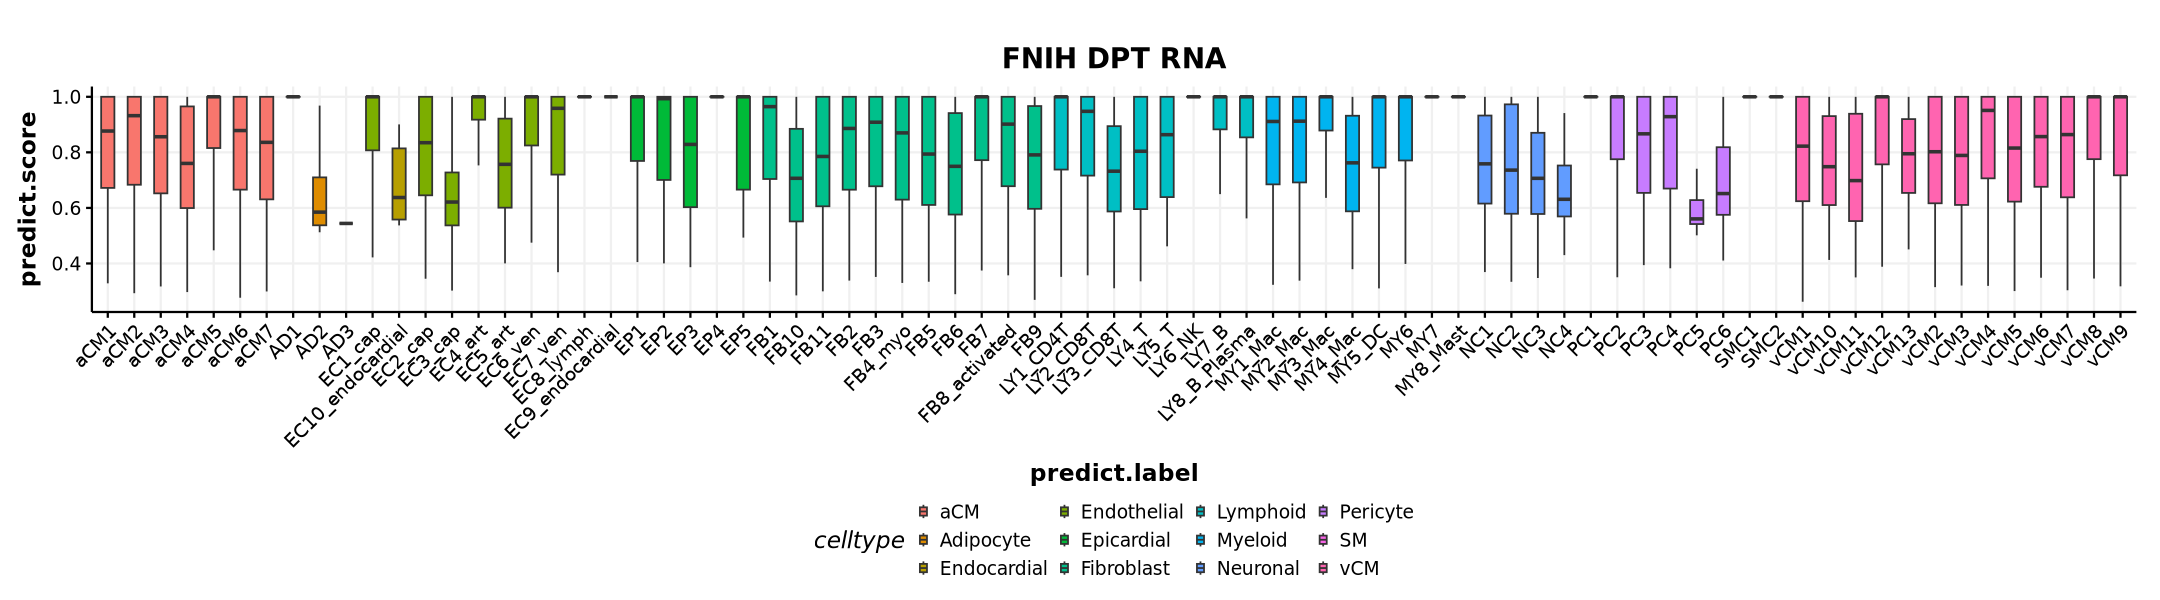

In [288]:
### current CCA, batch + sex harmony
options(repr.plot.width = 18, repr.plot.height = 5)
flist2 %>% 
filter(dataset == "CAREHF") %>%
ggplot(aes(x = predict.label, y = predict.score, fill = celltype)) + 
geom_boxplot(width = 0.5, coef = 2, outlier.shape = NA) +
theme_Publication() + ggtitle("CAREHF Multiome RNA") + 
theme(axis.text.x = element_text(angle = 45, hjust = 1)) 

flist2 %>% 
filter(dataset == "DPT") %>%
ggplot(aes(x = predict.label, y = predict.score, fill = celltype)) + 
geom_boxplot(width = 0.5, coef = 2, outlier.shape = NA) +
theme_Publication() +  ggtitle("FNIH DPT RNA") + 
theme(axis.text.x = element_text(angle = 45, hjust = 1)) 

In [414]:
### deposit all cells (good or bad)
obj@meta.data$predict.subtype <- obj@meta.data$predict.subtype.score <- NULL
obj@meta.data[obj$orig.ident == "DPT", c("predicted.cellsubtype", "predicted.cellsubtype_scores")] <- flist2[rownames(obj@meta.data[obj$orig.ident == "DPT",]), c("predict.label", "predict.score")]
obj@meta.data[obj$orig.ident == "CAREHF", c("predicted.cellsubtype", "predicted.cellsubtype_scores")] <- flist2[rownames(obj@meta.data[obj$orig.ident == "CAREHF",]), c("predict.label", "predict.score")]

obj@meta.data[obj$orig.ident == "DPT", c("predicted.celltype", "predicted.celltype_scores")] <- pred1[rownames(obj@meta.data[obj$orig.ident == "DPT",]), c("predict.label", "predict.score")]
obj@meta.data[obj$orig.ident == "CAREHF", c("predicted.celltype", "predicted.celltype_scores")] <- pred2[rownames(obj@meta.data[obj$orig.ident == "CAREHF",]), c("predict.label", "predict.score")]

obj$integrated_majortype <- obj$integrated_subtype <- "0"
gcells <- c(rownames(obj@meta.data[obj$orig.ident %in% c("DPT", "CAREHF") & obj$predicted.celltype_scores >= 0.9,]),
            rownames(obj@meta.data[obj$orig.ident == "MULTIOME",]))
obj@meta.data[gcells,]$integrated_majortype <- "1"

gcells <- c(rownames(obj@meta.data[obj$orig.ident %in% c("DPT", "CAREHF") & obj$predicted.cellsubtype_scores >= 0.8,]),
            rownames(obj@meta.data[obj$orig.ident == "MULTIOME",]))
obj@meta.data[gcells,]$integrated_subtype <- "1"


obj$nn2.cell_subtype <- obj$nn2.celltype <- "Low quality"
obj@meta.data[obj$integrated_subtype == "1" & obj$orig.ident != "MULTIOME", ]$nn2.cell_subtype <- gsub("label_", "", obj@meta.data[obj$integrated_subtype == "1" & obj$orig.ident != "MULTIOME", ]$predicted.cellsubtype)
obj@meta.data[obj$integrated_subtype == "1" & obj$orig.ident == "MULTIOME", ]$nn2.cell_subtype <- obj@meta.data[obj$integrated_subtype == "1" & obj$orig.ident == "MULTIOME", ]$cell.sub_types
obj@meta.data[obj$integrated_majortype == "1" & obj$orig.ident != "MULTIOME", ]$nn2.celltype <- gsub("label_", "", obj@meta.data[obj$integrated_majortype == "1" & obj$orig.ident != "MULTIOME", ]$predicted.celltype)
obj@meta.data[obj$integrated_majortype == "1" & obj$orig.ident == "MULTIOME", ]$nn2.celltype <- obj@meta.data[obj$integrated_majortype == "1" & obj$orig.ident == "MULTIOME", ]$cell.major_types

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



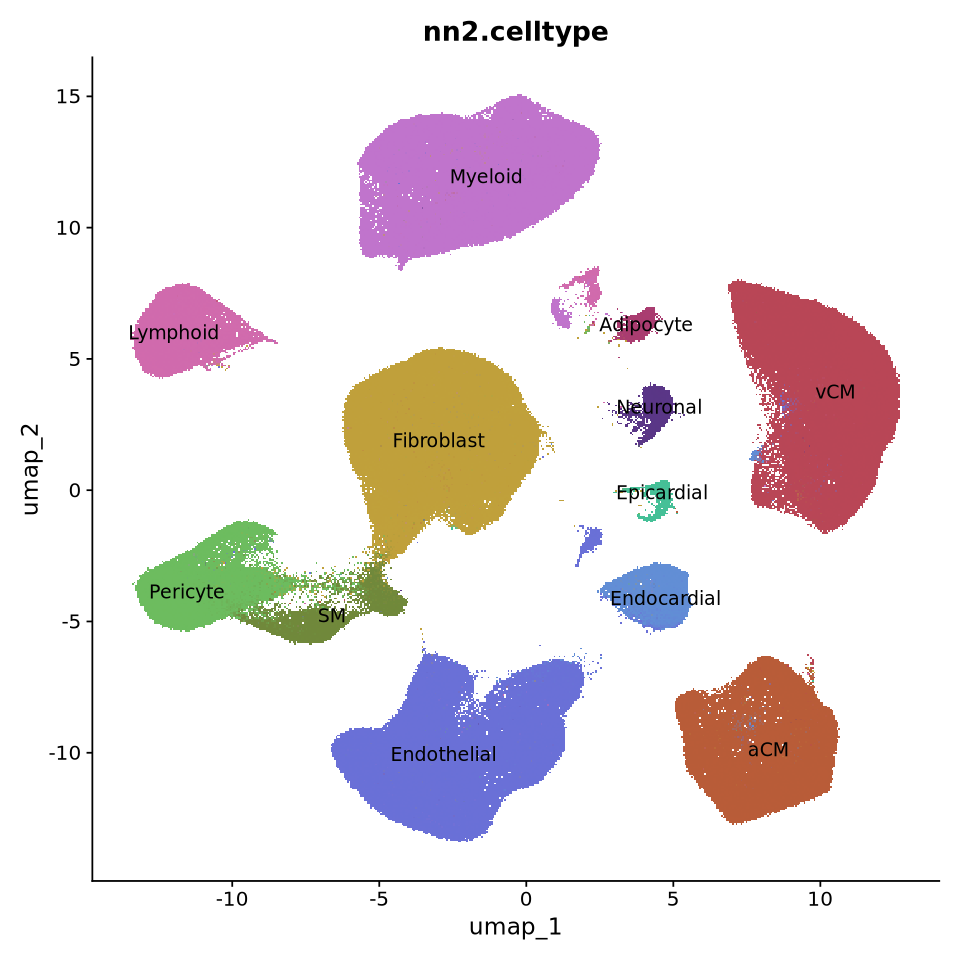

In [381]:
options(repr.plot.width = 8, repr.plot.height = 8)
DimPlot(obj, group.by = "nn2.celltype", cols = celltype_colors, label = T) + NoLegend()

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



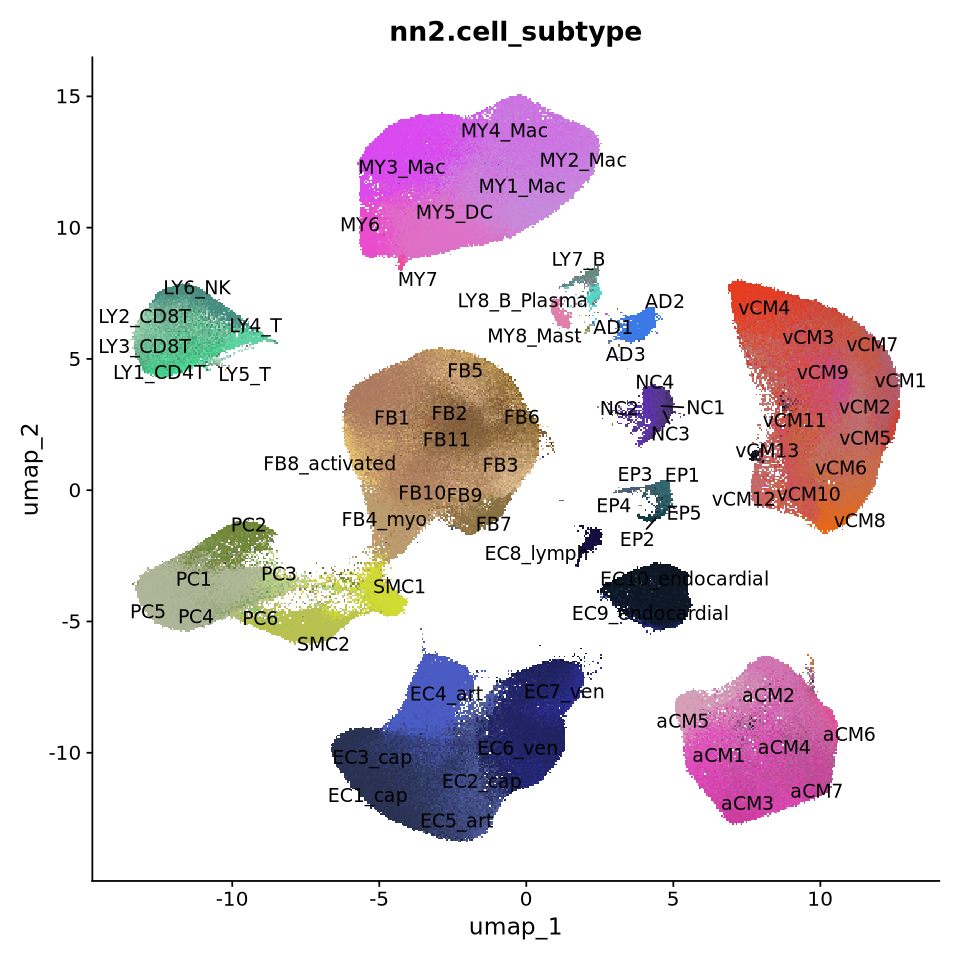

In [382]:
DimPlot(obj, group.by = "nn2.cell_subtype", cols = cellsubtype_colors, label = T, repel = T) + NoLegend()

In [447]:
qs::qsave(obj, "integration/CAREHF_Multiome_DPT_RNA_int.obj.qs")